# Data Preprocessing and Descriptive Analytics of KKBox Dataset

*** Our goal is to accurately predict customer churn***

[WSDM KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge)

## The Business Problem

KKBox is the leader in music streaming in Asia and their business model is based on paid user accounts and advertising revenue with the former being a significant contributor. The client (KKBox) wants a predictive model of customer churn built.

Stage 1 requires descriptive analytics. We will present assumptions about the data & the intended model as we preprocess and explore...

In [1]:
# Importing pandas et al is a given for data scientists working with flat files

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import re

In [2]:
# As the name implies, this csv holds subscriber information

members = pd.read_csv('members_v2.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
1,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,20110918
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1,0,NaN,7,20110918
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,4,28,female,9,20110920


In [3]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795090 entries, 0 to 795089
Data columns (total 6 columns):
msno                      795090 non-null object
city                      795090 non-null int64
bd                        795090 non-null int64
gender                    318249 non-null object
registered_via            795090 non-null int64
registration_init_time    795090 non-null int64
dtypes: int64(4), object(2)
memory usage: 36.4+ MB


In [4]:
# Confirming location of missing values in our dataframe...

members.isnull().any()

msno                      False
city                      False
bd                        False
gender                     True
registered_via            False
registration_init_time    False
dtype: bool

In [5]:
members['gender'].describe()

count     318249
unique         2
top         male
freq      168385
Name: gender, dtype: object

** The missing values in the age variable are likely customers ignoring the age field during sign-up. We will create a level of the gender variable for missing values. **

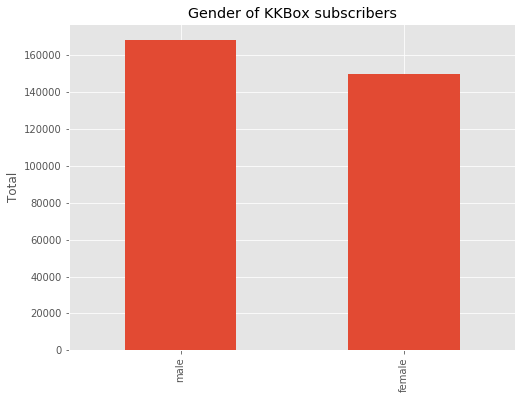

In [6]:
gender = members['gender'].value_counts()
gender.plot(kind='bar',stacked=True, figsize=(8,6))

plt.ylabel('Total')
plt.title("Gender of KKBox subscribers")
plt.show()

In [7]:
# Creating a 'missing' category/level for the gender variable

members['gender'] = members['gender'].fillna('missing')

In [8]:
# Investigating the age variable...

print members['bd'].max()
members['bd'].min()

2016


-3152

**The bd column is a placeholder for subscriber age whose entries range from -3152 to 2016**

*What assumptions can we make about this variable?*

- It is possible this field is stored in a Unix-like database that holds dates as either positive or negative offsets of 1970
- The values could also be user entry errors

As KKBox only accepts registrants from within Asia, we had someone from Hong Kong sign up and send us screenshots of the DOB data entry:

<table><tr><td><img src="correct.jpg" style="width: 250px;"></td><td><img src="wrong1.jpg" style="width: 250px;"></td><td><img src="wrong2.jpg" style="width: 250px;"></td></tr></table>

## Clearly, KKbox has data validation issues they need to attend to...

Our observations clearly rule out the Unix case... 

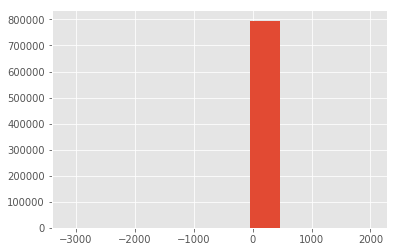

In [9]:
members['bd'].hist()
plt.show()

** Data cleaning required.**

In [19]:
members['bd'][(members['bd'] < 0)].count()

68

In [18]:
members['bd'][(members['bd'] > 150)].count()

76

In [21]:
members['bd'][(members['bd'] == 0)].count()

480509

*** The number of subscribers of age 0 is staggering ***

In [15]:
print float(len(members['bd'][members['bd'] == 0]))*100/len(members['bd']),'% of subscribers in dataset are age 0'

60.4345420015 % of subscribers in dataset are age 0


In [14]:
# getting the count of age values from 0 - 10 to get a picture of the kid subscribers are in our dataset
members['bd'][(members['bd'] >= 0) & (members['bd'] < 13)].value_counts()

0     480509
12        20
1         19
6         15
7         12
10         9
5          9
3          9
2          9
11         8
8          8
9          7
4          7
Name: bd, dtype: int64

In [16]:
# counting how many observations fall between 80 & 120. We will assume that users older than 120 are invalid.
members['bd'][(members['bd'] > 80) & (members['bd'] < 120)].count()

466

In [17]:
members['bd'][(members['bd'] > 120) & (members['bd'] < 150)].value_counts()

139    2
128    2
129    1
122    1
121    1
132    1
133    1
148    1
131    1
123    1
144    1
Name: bd, dtype: int64

In [23]:
members['bd'][(members['bd'] > 80) & (members['bd'] < 120)].value_counts()

106    70
117    51
112    44
102    22
84     21
95     17
91     16
103    16
105    16
89     14
81     13
92     12
97     12
107    11
87     11
93     10
90      9
96      9
94      9
100     8
111     8
86      7
85      7
83      7
98      7
109     7
104     6
88      6
101     5
82      5
119     3
110     2
116     2
99      1
113     1
114     1
Name: bd, dtype: int64

** We will assume there are no supercentenarians beyond 120 years of age and mark such occurrences as invalid. **

[Link here](https://en.wikipedia.org/wiki/List_of_supercentenarians_from_Asia)

** We will also assume children aged 1 - 10 have been signed up by their parents. We do not expect this assumption to affect our model significantly especially since there are so few of them. **

In [22]:
members.loc[members['bd'] < 0, 'bd'] = np.nan
members.loc[members['bd'] > 120, 'bd'] = np.nan

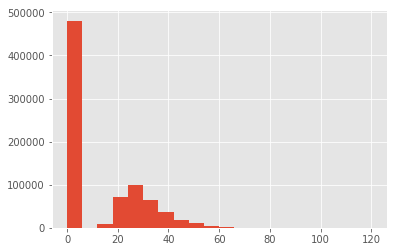

In [23]:
members['bd'].hist(bins=20)
plt.show()

In [24]:
members['bd'].median()

0.0

** Let's found out what proportion of our age variable is valid **

In [26]:
print float(members['bd'][members['bd'] > 0].count())*100/len(members['bd']),'% is valid'

39.5457118062 % is valid


In [27]:
members['bd'][members['bd'] > 0].median()

28.0

In [28]:
members['bd'] = members['bd'].fillna(28)

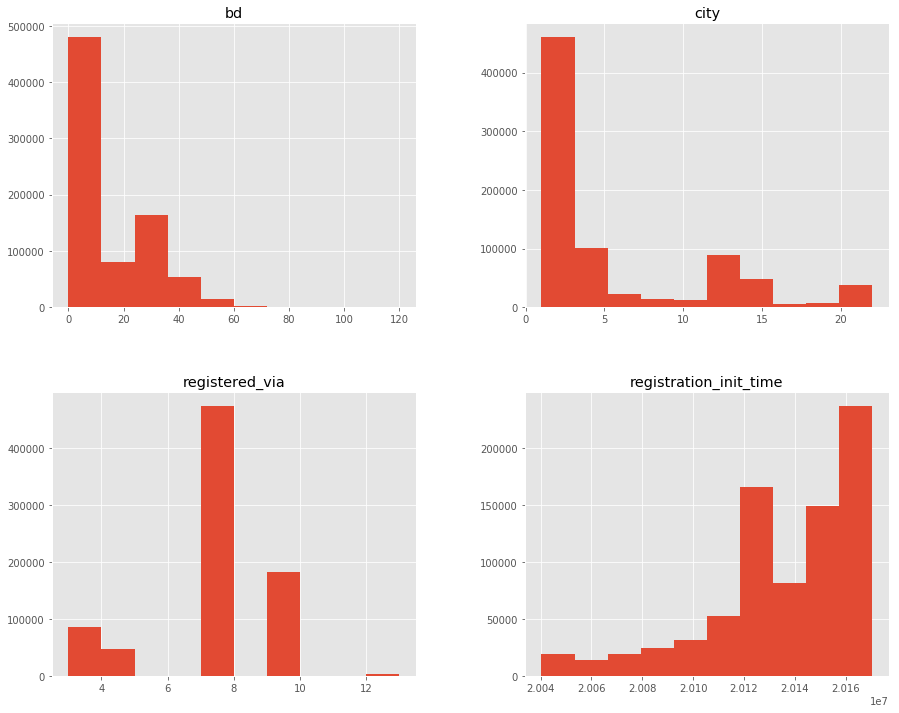

In [30]:
members.hist(figsize=(15,12))
plt.show()

** We must consider the effect of assigning the median age to 60% of our observations (nulls);  **

We will investigate three plans of action:
1. Run Random Forest Classifier to identify the most important features and disregard age if it is not an important feature.

2. If age is an important feature, we will cluster our dataset and assign median of each cluster to nulls.
    - While it has been found to be just as efficient as using more complex statistical techniques in classification and clustering, [link here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4350881/), we must realize that assigning the median value to 60% of our data will do no good to our model.

    - We will try to cluster our observations into three to five groups and assign the median of these clusters to the null values.
        
    - The question of how many clusters to use in an analysis is highly subjective and has been written about extensively. We hope to cluster based on age and split our data into the following groups:
        
        - Age 0 - 12
        - Age 13 - 20
        - Age 21 - 33
        - Age 34 - 54
        - Age 55 and above
        
    We believe this is a common-sense approach...
   
3. Failing the above, we will assume a linear relationship between the other variables and age and run multiple linear regression to impute the missing ages.
    - At this time, we do not believe this assumption to be valid; a linear relationship does not seem to exist between age and the other variables. We can only confirm this by generating linear plots.
    
    
[Click here to view the Random Forest Model](model.ipynb)

In [46]:
# We will transform the variables of time

from datetime import datetime

members['registration_init_time'] = members['registration_init_time'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d').date())
#members['expiration_date'] = members['expiration_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d').date())

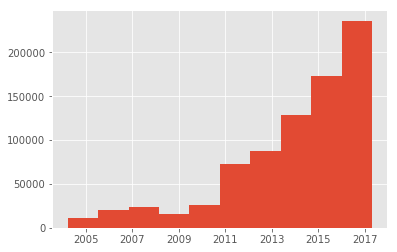

In [47]:
members['registration_init_time'].hist()
plt.show()

In [48]:
print members['registration_init_time'].max()
members['registration_init_time'].min()

2017-04-24


datetime.date(2004, 3, 26)

In [49]:
members['registration_init_days'] = members['registration_init_time']-datetime(1970,1,1).date()

In [32]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795090 entries, 0 to 795089
Data columns (total 6 columns):
msno                      795090 non-null object
city                      795090 non-null int64
bd                        795090 non-null float64
gender                    795090 non-null object
registered_via            795090 non-null int64
registration_init_time    795090 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 36.4+ MB


In [33]:
members.isnull().any()

msno                      False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
dtype: bool

In [34]:
members.to_csv('members_clean_v2.csv', index=False)

### More Graphical Discovery

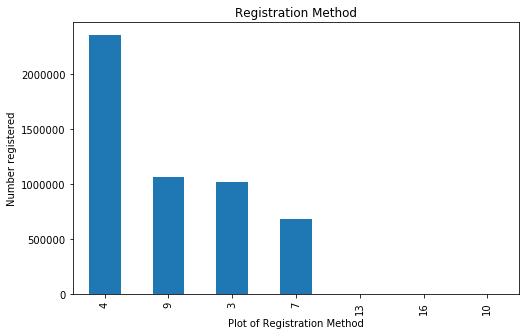

In [43]:
registered_via = members['registered_via'].value_counts()
registered_via.plot(kind='bar',stacked=True, figsize=(8,5))

plt.xlabel('Plot of Registration Method')
plt.ylabel('Number registered')
plt.title("Registration Method")
plt.show()

*** Pending confirmation from a reliable data dictionary, it is safe to assume that city 1 is Taipei, KKBox being a Taiwanese company... ***

In [15]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      category
bd                        int64
gender                    object
registered_via            category
registration_init_time    int64
expiration_date           int64
dtypes: category(2), int64(3), object(2)
memory usage: 204.9+ MB


In [32]:
members['expiration_date'].head()

0    2015-05-26
1    2016-12-24
2    2016-03-09
3    2016-11-07
4    2017-02-05
Name: expiration_date, dtype: object

In [33]:
members['registration_init_time'].describe()

count        5116194
unique          4763
top       2015-10-09
freq           11550
Name: registration_init_time, dtype: object

In [34]:
for column in members:
    print members[column].describe()

count                                          5116194
unique                                         5116194
top       lLEwGD3UEH/O8YCBrUGPRQUUKVi/sCnJULwGIU49Kj4=
freq                                                 1
Name: msno, dtype: object
count     5116194
unique         21
top             1
freq      3541998
Name: city, dtype: int64
count    5.112225e+06
mean     9.665540e+00
std      1.500244e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.100000e+01
max      1.000000e+02
Name: bd, dtype: float64
count     5116194
unique          3
top       missing
freq      3354778
Name: gender, dtype: object
count     5116194
unique          7
top             4
freq      2351944
Name: registered_via, dtype: int64
count        5116194
unique          4763
top       2015-10-09
freq           11550
Name: registration_init_time, dtype: object
count        5116194
unique          5604
top       2017-09-30
freq          137652
Name: expiration_date, dtype: object


In [35]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      category
bd                        float64
gender                    object
registered_via            category
registration_init_time    object
expiration_date           object
dtypes: category(2), float64(1), object(4)
memory usage: 204.9+ MB


** So... We have 7 input variables - 2 categorical (registered via, gender, and city), 4 objects, and age **

In [45]:
members.to_csv("members_trf_data.csv", index=False)

## We will now attempt to describe the transactions data...

In [44]:
import pylab
import seaborn as sns

trans = pd.read_csv("transactions.csv")
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [46]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 1.4+ GB


** The data has 21,547,745 million rows of data and 9 columns.**

- **msno:** user id
- **payment_method_id:** payment method
- **payment_plan_days:** length of membership plan in days
- **plan_list_price:** in New Taiwan Dollar (NTD)
- **actual_amount_paid:** in New Taiwan Dollar (NTD)
- **is_auto_renew**
- **transaction_date:** format %Y%m%d
- **membership_expire_date:** format %Y%m%d
- **is_cancel:** whether or not the user canceled the membership in this transaction.

**Converting Date Columns - transaction_date and membership_expire_date**

In [48]:
trans['transaction_date'] = trans['transaction_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
trans['membership_expire_date'] = trans['membership_expire_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

KeyboardInterrupt: 

**Testing for NULL values**

In [49]:
trans.isnull().sum()

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

In [50]:
len(trans['msno'].unique())

2363626

In [51]:
#Checking the unique payment method ids

print(trans['payment_method_id'].unique())
print("The number of unique ids used are:", trans['payment_method_id'].nunique())

[41 39 21 37 40 34 33 31 23 38 19 24 14 36 27 35 30 29 28 22 26 32 25 20 17
  5 18 11  7 13 12 16 10 15  8  6  3  2  4  1]
('The number of unique ids used are:', 40)


In [52]:
#Popularity of payment_methods among transactions

paymentmethod = trans.groupby('payment_method_id').size()
paymentmethod.sort_values()

payment_method_id
1           12
4           15
2           52
3          210
6          466
5          474
8          657
7         1094
10        1326
15        1479
11        2129
12        3834
26        4591
13        6571
17        7437
16       11064
14       13621
25       13780
18       16177
24       16196
22       20130
21       22883
20       28278
19       32073
23       42386
27       62525
28       95733
29      113885
32      146481
30      160957
31      252342
33      411164
35      541399
34      731539
36      855115
37     1007689
39     1466655
38     1703590
40     2225283
41    11526454
dtype: int64

**The users are grouped by the number of transactions in the data**

In [53]:
users_by_trans = trans.groupby(['msno']).size()
print("The users with multiple transactions: ",sum(users_by_trans.values > 1))
print("The users with one transaction: ",sum(users_by_trans.values == 1))

('The users with multiple transactions: ', 1771525)
('The users with one transaction: ', 592101)


*** Variable: Payment_plan_days ***

In [54]:
print trans['payment_plan_days'].unique()
print trans['is_cancel'].unique()
print trans['plan_list_price'].unique()
print trans['is_auto_renew'].unique()

[ 30   0  10  31   7 410 195 100 395   1 180 120  60 400  14 360 200  35
  90  21 240 450  70  80  45 110 365  66 270  99   2 230   3  15 425 415
  95]
[0 1]
[ 129  149    0   99  100  119  150 1788  180  894   50  120  500 1599  536
  799  480  477  596 1200  300  930  699  450   35  447  105  298  134 1000
  350  124  400    1  131  126   10 1150   70 1520  265  143 2000  800   15
   30  210  760  600 1825   44]
[1 0]


In [55]:
#Converting to categorical data

trans['payment_method_id'] = trans['payment_method_id'].astype('category')
trans['is_auto_renew'] = trans['is_auto_renew'].astype('category')
trans['is_cancel'] = trans['is_cancel'].astype('category')
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             category
transaction_date          datetime64[ns]
membership_expire_date    int64
is_cancel                 category
dtypes: category(3), datetime64[ns](1), int64(4), object(1)
memory usage: 1.0+ GB


## Data Exploration and Visualisation

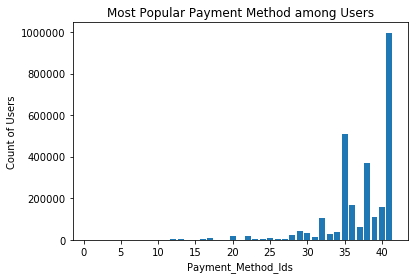

In [56]:
#Popularity of Payment method among users
#This shows us the payment method used by most users within the transactions dataset
paymentmethod = trans.groupby('payment_method_id')['msno'].nunique()
x = paymentmethod.keys()
y = paymentmethod
plt.bar(x,y,0.8)
#plt.ylim([0,12000000])
plt.title('Most Popular Payment Method among Users')
plt.xlabel('Payment_Method_Ids')
plt.ylabel('Count of Users')
plt.show()

##### INSIGHTS: <br>The most popular method of payment among users is 'payment_method_id' = 41

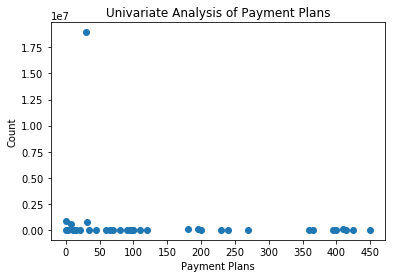

In [57]:
#Univariate Analysis of Membership Plan
paymentplan = trans.groupby('payment_plan_days').size()
x = paymentplan.keys()
y = paymentplan
plt.scatter(x,y)
plt.xticks(np.arange(0, 500, 50))
plt.title('Univariate Analysis of Payment Plans')
plt.xlabel('Payment Plans')
plt.ylabel('Count')
plt.show()

##### INSIGHTS: <br>Most transactions have been performed for Payment Plan of 30 days.<br>                                                                                                                                          There are transactions with Payment Plan of 0 days. This data needs to be analysed further.<br>                                                                                                The largest plan is for about 450 days i.e for 15 months

In [58]:
#Number of Transactions on Auto_Renewal

auto_renewal = trans.groupby('is_auto_renew').size()

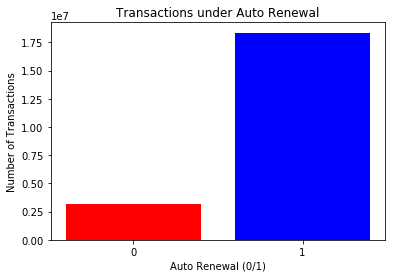

In [59]:
x = (0,1)
y = auto_renewal
plt.bar(x,y,0.8)
plt.xticks([0,1])
plt.title('Transactions under Auto Renewal')
plt.xlabel('Auto Renewal (0/1)')
plt.ylabel('Number of Transactions')
plt.bar(x[0],y[0], color = 'red') #making non auto-renewals => RED
plt.bar(x[1],y[1], color = 'blue') #making auto-renewals => BLUE
plt.show()

##### INSIGHTS:<br> The bulk of transactions are auto-renewals.

In [60]:
#Number of Transaction that are Cancelled
cancelled = trans.groupby('is_cancel').size()

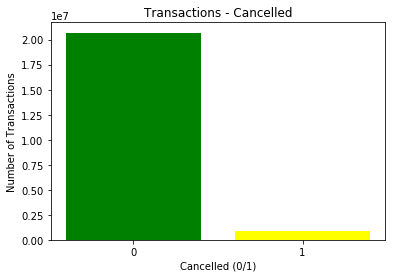

In [61]:
x = cancelled.keys()
y = cancelled
plt.bar(x,y,0.8)
plt.xticks([0,1])
plt.title('Transactions - Cancelled')
plt.xlabel('Cancelled (0/1)')
plt.ylabel('Number of Transactions')
plt.bar(x[0],y[0], color = 'green') #cancellation - no => GREEN
plt.bar(x[1],y[1], color = 'yellow') #cancellation - yes => YELLOW
plt.show()

In [62]:
#Checking for trends across the dates

trans_dates = trans['transaction_date'].value_counts()

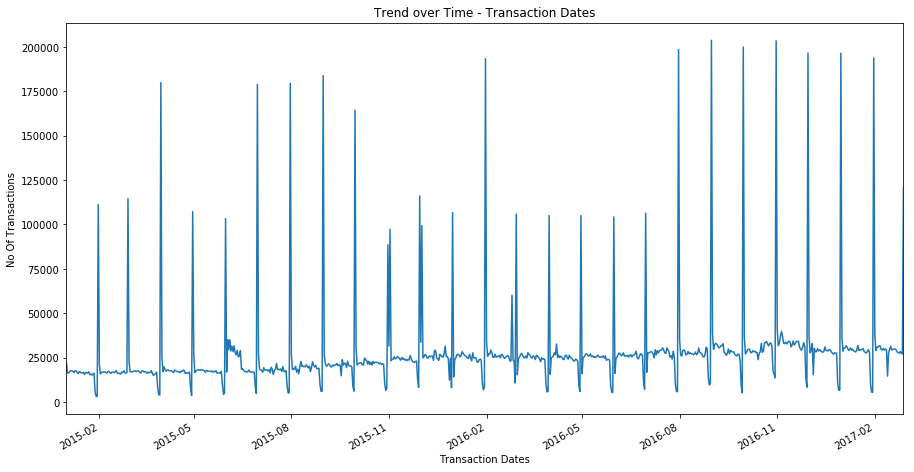

In [63]:
trans_dates.plot(kind ="line",figsize=(15,8))
plt.title("Trend over Time - Transaction Dates")
plt.xlabel("Transaction Dates")
plt.ylabel("No Of Transactions")
plt.show()

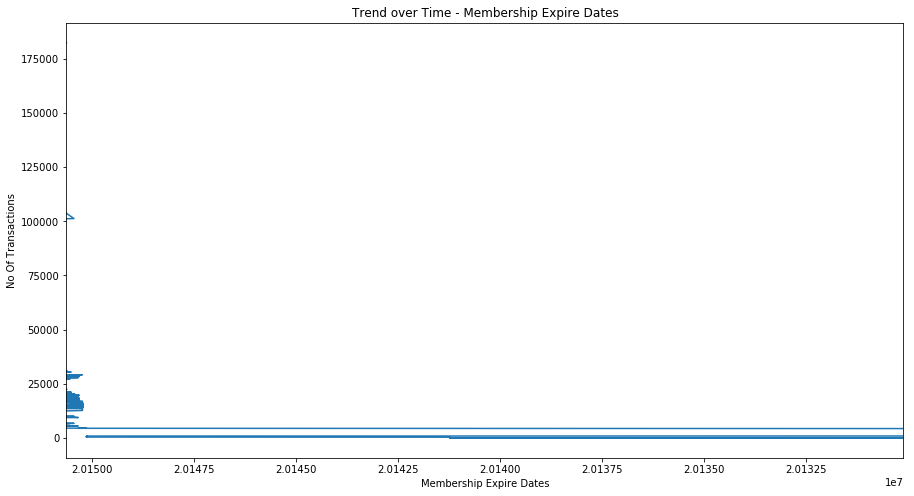

In [64]:
#Looking at Expiration Dates
expire_dates = trans['membership_expire_date'].value_counts()
expire_dates.plot(kind = "line",figsize=(15,8))
plt.title("Trend over Time - Membership Expire Dates")
plt.xlabel("Membership Expire Dates")
plt.ylabel("No Of Transactions")
plt.show()

##### INSIGHTS: From here it is seen that the data starts from 1972, but there is no useful information here.

In [65]:
#Comparing Transaction Dates and Membership Expiration Dates
trans_dates = trans['transaction_date'].value_counts()
expire_dates = trans['membership_expire_date'].value_counts()
expire_dates_n = expire_dates['2015-01-01':'2017-02-28'] #Retaining only dates from 2015-2017
trans_dates.plot(kind ="line",figsize=(15,8))
expire_dates_n.plot(kind = "line",figsize=(15,8))
plt.title("Trend for Transaction Date and Membership Expiration Dates")
plt.xlabel("Dates")
plt.ylabel("No Of Transactions")
plt.show()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [2015-01-01] of <type 'str'>

In [66]:
#Since this data was mess to read, we drilled down further by months
#Counting the number of transactions by month

trans.index = trans['transaction_date']
trans_month = trans.resample('M').count()

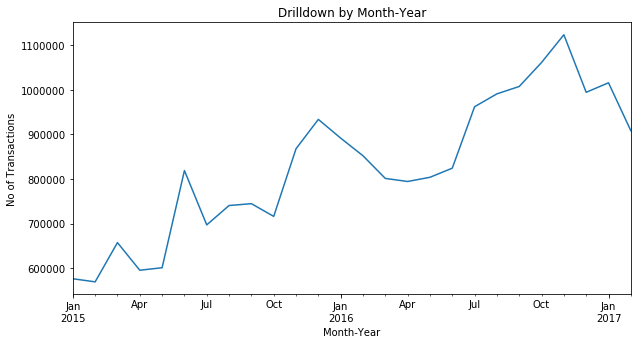

In [67]:
trans_month['msno'].plot(kind = "line",figsize=(10,5))
plt.title("Drilldown by Month-Year")
plt.xlabel("Month-Year")
plt.ylabel("No of Transactions")
plt.show()

In [5]:
members = pd.read_csv("members_trf_data.csv")

In [3]:
train = pd.read_csv("train.csv")

In [4]:
train.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
msno        992931 non-null object
is_churn    992931 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.2+ MB


In [7]:
merged_data = members.merge(train, on="msno")

In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876143 entries, 0 to 876142
Data columns (total 8 columns):
msno                      876143 non-null object
city                      876143 non-null int64
bd                        875623 non-null float64
gender                    876143 non-null object
registered_via            876143 non-null int64
registration_init_time    876143 non-null object
expiration_date           876143 non-null object
is_churn                  876143 non-null category
dtypes: category(1), float64(1), int64(2), object(4)
memory usage: 54.3+ MB


In [8]:
merged_data.head(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn
0,75rp8sCaeatezkb6c0I133UakcSDuKcc5ia0b0Q+JS4=,1,24.0,male,3,2015-11-29,2017-09-25,1
1,1Nqjt8ykQceNOmuRrh9bcgvicDfLlj+jkgx7+Dd0Rk0=,1,0.0,missing,7,2016-04-10,2017-09-09,0
2,gsDjjsDaM2cXEorLK8Qctgf6eO3NU1QgYK5q4j3dhfc=,1,0.0,missing,7,2016-06-08,2017-10-07,0
3,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0.0,missing,7,2011-08-20,2017-09-20,0
4,ZF5OFkIsel+d4VJ4uaOMjThPZRF6XRowQ9ZA/RCvBeY=,1,0.0,missing,7,2016-01-30,2017-10-03,0
5,eMgBkkzRviMP0wvtf/wALwYpyVyfxfCfisRJVAlh+3g=,1,0.0,missing,9,2011-04-02,2017-09-22,0
6,/tdbyriKXZb5TfSyjE4qUl/dppoT+cZtPece2gErPck=,5,0.0,missing,7,2010-12-20,2017-09-27,0
7,jgyrKBspt3xkH/kTo6tkHXcjSZ7Z8W7D7YLonV5Z6Rc=,1,0.0,missing,7,2016-01-17,2017-09-17,0
8,9r83QcYAXqlzqgmx1s4yHHEAbklPdD32JL1Z6UTT0C4=,15,42.0,female,9,2007-08-13,2017-09-20,0
9,k4Zdbf2Sh1ZF1eamTPH72VLDF4QlKLnDJVzutXfkrOA=,1,0.0,missing,7,2016-03-29,2017-10-01,0


In [9]:
merged_data.tail(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn
876133,qerkaiyMZF7AbECbeFGn8MC+sI2jL9RKPxMiB1a+8i4=,1,0.0,missing,7,2012-01-10,2017-10-02,0
876134,F425udhQ9cUbevDfBPiXvZ15jup1zd/dtUppcCcxlR0=,1,0.0,missing,7,2012-01-17,2017-09-24,0
876135,CMJ4ETek1UtTBVgnemgECkCSwIex1Y2//TDyMAxkWf8=,4,34.0,female,9,2013-09-20,2017-09-30,0
876136,ezKU31rCHfU1zwF8fszflH9o+Jqt/FvprbNDZVMM1oU=,4,43.0,male,9,2007-05-02,2018-04-28,0
876137,2CNRAUI9AOoNq+52NZ7WLzD40ct+rJvbFvNcQmiaNpM=,22,28.0,male,7,2012-06-09,2017-09-11,0
876138,61vxlJL2MZoLTf6f965Ka681UOQpdNFrMZb8bISHxbE=,1,0.0,missing,3,2014-02-08,2017-08-30,0
876139,PdkHqOPuvE5+qy3gXU+9enRtlf1Lzsqp530N6j64/Xo=,1,0.0,missing,7,2011-12-23,2017-09-10,0
876140,ZxGaoCP7m8QfeW+72Ohvp6ZMKFmNtLb1ct0waBiDDig=,13,32.0,female,9,2010-07-31,2017-09-26,0
876141,F10Hn+qIV08k7nd7i2jdGEEduTMJQjIAgF03dI5t65k=,1,0.0,missing,7,2016-11-29,2017-09-30,0
876142,VJmQvIH9x9SHfo//AMHJaY1MSQw9FVy4Vhjxxk30pCM=,1,0.0,missing,7,2011-03-05,2017-09-08,0


In [10]:
merged_data["is_churn"].describe()

count    876143.000000
mean          0.065793
std           0.247920
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_churn, dtype: float64

In [11]:
merged_data['is_churn'] = merged_data['is_churn'].astype('category')

In [12]:
merged_data["is_churn"].describe()

count     876143
unique         2
top            0
freq      818499
Name: is_churn, dtype: int64

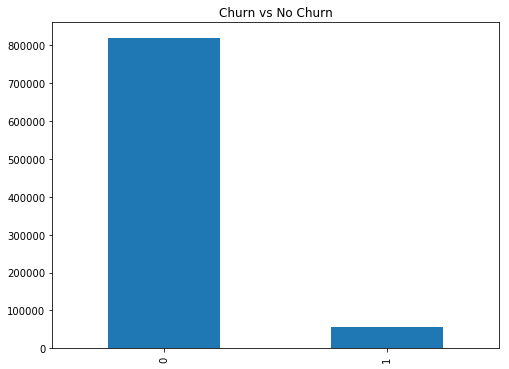

In [13]:
churn = merged_data['is_churn'].value_counts()
churn.plot(kind='bar',stacked=True, figsize=(8,6))

plt.title("Churn vs No Churn")
plt.show()

In [16]:
merged_data.corr()

,city,bd,registered_via
city,1.000000,0.638098,0.017878
bd,0.638098,1.000000,0.083805
registered_via,0.017878,0.083805,1.000000


In [ ]:
churners = merged_data